### Car Fuel Consumption from Kaggle
## 検討目的：回帰によるconsumeの予測

In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
# 以下，NNで追加
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf

Since a few months, i write down the data of my car's display after each ride; while regularly changing the gas type.

|No.|data name|data explanation|
| :--- | :---: | ---: |
|1| distance | (km) |
|2| consume | consume(L/100km) |
|3| speed | the average speed(km/h) |
|4| temp_inside | the temprature inside(℃) |
|5| temp_outside | the temprature outside(℃) |
|6| specials | anything special |
|7| gas_type | the gas type i was using |
|8| AC | if the air contion was on |
|9| rain | if it was raining |
|10| sun | if it was sunny |
|11| refil l liters| how much I was buying |
|12| refil l gas| which gas type (SP98 in winter or E10 in spring )  I was buying |



# 1. データ読み込みと基礎統計量の確認

In [123]:
# ファイル読み込み
df_cp = pd.read_csv('../data/carfuel_consumption.csv')
df_cp.loc[100:110]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
100,"5,3","4,1",34,NaN,9,NaN,SP98,0,0,0,NaN,NaN
101,"26,2","5,8",71,21,8,AC rain,SP98,1,1,0,NaN,NaN
102,"18,8",5,62,NaN,9,rain,SP98,0,1,0,NaN,NaN
103,"4,9","6,9",25,21,12,rain,SP98,0,1,0,NaN,NaN
104,"12,4","5,4",18,21,11,AC rain,SP98,1,1,0,NaN,NaN
105,"22,9","5,3",45,"20,5",7,NaN,SP98,0,0,0,NaN,NaN
106,"162,7","5,5",75,23,1,NaN,SP98,0,0,0,45,SP98
107,"4,9","6,5",26,21,1,NaN,SP98,0,0,0,NaN,NaN
108,"11,8","4,7",36,21,4,NaN,SP98,0,0,0,NaN,NaN
109,"16,6","5,1",56,21,7,NaN,SP98,0,0,0,NaN,NaN


In [148]:
df_cp.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000


In [124]:
# 数値の基礎情報の確認
df_cp.info()
# 加工用のデータセット作成　df_cp → df_cp2
df_cp2=df_cp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


# 2.前処理（説明変数の充実化）

In [125]:
#　文字データを数値データに変換
df_cp2['distance']=df_cp2['distance'].str.replace(',','.').astype(float)
df_cp2['consume']=df_cp2['consume'].str.replace(',','.').astype(float)
df_cp2['temp_inside']=df_cp2['temp_inside'].str.replace(',','.').astype(float)

#　refill liters，refill gas，specialsはデータ数が少ないため利用データから除外
df_cp2 = df_cp2.drop(['refill liters', 'refill gas'], axis=1)
df_cp2 = df_cp2.drop(['specials'], axis=1)

In [126]:
# 文字列データの内訳確認
df_cp2['gas_type'].unique()

array(['E10', 'SP98'], dtype=object)

In [127]:
#　文字列データの数値化
#　E10を0に，SP98を1に変換して，数値化
df_cp2['gas_type'] = df_cp2['gas_type'].str.replace('E10', '0').astype(str)
df_cp2['gas_type'] = df_cp2['gas_type'].str.replace('SP98', '1').astype(str)
df_cp2['gas_type'] = df_cp2['gas_type'].astype(int)

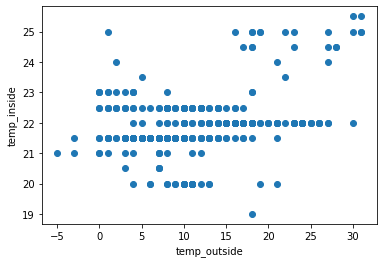

In [128]:
# temp_insideの欠測値の内挿
# 
yt = df_cp2['temp_inside'].values
xt = df_cp2['temp_outside'].values
plt.scatter(xt,yt)

plt.xlabel('temp_outside')
plt.ylabel('temp_inside')
plt.show()

#reg = LinearRegression(fit_intercept=True)
#reg.fit(Xt,yt)

In [129]:
# temp_insideの中央値で補完
df_cp2 = df_cp2.fillna({'temp_inside':df_cp2['temp_inside'].mean()})

In [149]:
#正規化処理

minmax = StandardScaler()
minmax.fit_transform(df_cp2['distance'].values)

ValueError: Expected 2D array, got 1D array instead:
array=[ 28.   12.   11.2  12.9  18.5   8.3   7.8  12.3   4.9  11.9  12.4  11.8
  12.3  24.7  12.4  17.3  33.4  11.8  25.9  11.8  25.3  14.2  17.9  11.8
  12.3  12.4  18.4  18.4  18.3  18.4  12.3  11.8  12.3  32.6  19.   12.1
  20.    4.9  11.8  12.3  12.4   4.5  11.7  10.2   5.4   2.   14.2  16.
  11.8  27.3  11.8  10.6  11.6  13.1   6.1 153.5  11.8  12.3  12.4  12.3
   2.9   2.1   9.8   6.8  12.4  12.4  11.8  12.3  14.   11.8  12.3   2.
  13.9   9.7  11.6  14.2  11.8  24.8  12.4  34.8  14.2   5.2  10.5  12.3
  11.8  12.3  13.2  13.   12.9  13.9  11.8  12.2  12.5  12.4  11.8  11.8
  12.5  15.7  12.9   6.4   5.3  26.2  18.8   4.9  12.4  22.9 162.7   4.9
  11.8  16.6  12.4  15.9   5.1  22.4  31.1   4.9  11.8  22.9  12.4  12.9
  11.8  12.2  24.8  14.2  11.8  12.2  24.7   6.8  17.3  11.8  15.9   5.1
  16.1  11.8   4.2  17.4  23.5  11.8  12.3  16.1  11.8  12.3  12.4   7.
  11.8  20.1  20.8   1.7  35.9  36.9  16.8   9.9  22.9  17.3  11.8  36.6
  44.9  11.8  21.6  39.4   5.1  26.6  53.2  18.9  43.5   6.1  16.4  12.3
  21.1  21.1  22.7  44.4  35.8  11.8  26.2  40.6  12.4  14.1  58.7  16.2
  12.3  12.3  12.4  31.8  12.3  51.6  38.6  12.3  81.2 130.3  67.2  43.7
  12.1  56.1  39.   11.8  38.5  28.2   2.9   6.1  19.6  22.2  13.6  12.6
   8.7   7.9   2.4   4.9  18.1  25.9   1.3  14.1  13.4   6.4  12.9  12.1
  15.7  16.2  12.8  19.   29.   12.1  12.3  24.8  12.9  11.8  31.4  19.
  13.   11.8  13.   11.8  27.1   5.2  19.   12.4  25.2  14.3  11.8  16.9
  12.4  17.4   9.2  12.3  13.   11.8  13.   12.3  12.3  12.5  31.5  11.8
  24.9  17.    2.   11.8   7.4  12.4   2.   14.   25.7  24.5  11.8   4.1
   4.2   4.2  16.   22.9  16.   15.4  16.    4.2 101.9  93.9  25.7  16.
  16.1  16.   16.   24.7  16.   15.4  16.   32.1  25.9  48.6  37.2  28.8
   6.7   7.4  17.3   6.6  14.3  13.3   8.3  12.7  16.5  20.6  16.3  18.7
  36.5  19.   16.6  29.9  16.   21.1  16.   11.9  10.1  31.9  18.7  10.8
  19.8  11.3  11.5  21.4  32.   41.9 211.  216.1  25.5  16.6  25.9  16.5
  22.1  16.6  15.4  16.5  15.4  18.4  39.5  21.5   4.8 100.9 129.7  16.6
  15.4  16.   16.   15.4  16.   21.   15.4  16.   16.1  16.   15.4  17.2
  16.6  18.3  16.1  16.   16.3  16.   18.3   4.5  17.    6.1   6.1  17.3
   6.   16.   15.4  15.4  16.   15.4  16.6  15.4  16.   15.4  16.   20.9
  32.1  15.3  28.5  11.9  14.5  16.6  16.2  16.7   8.3   5.5  13.6  16.
  16.1  16.   15.4  14.7].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# 3.前処理結果の概要確認

In [131]:
df_cp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     388 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null int32
AC              388 non-null int64
rain            388 non-null int64
sun             388 non-null int64
dtypes: float64(3), int32(1), int64(5)
memory usage: 25.8 KB


In [132]:
df_cp2.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.587629,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
df_cp2.loc[100:110]

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
100,5.3,4.1,34,21.929521,9,1,0,0,0
101,26.2,5.8,71,21.000000,8,1,1,1,0
102,18.8,5.0,62,21.929521,9,1,0,1,0
103,4.9,6.9,25,21.000000,12,1,0,1,0
104,12.4,5.4,18,21.000000,11,1,1,1,0
105,22.9,5.3,45,20.500000,7,1,0,0,0
106,162.7,5.5,75,23.000000,1,1,0,0,0
107,4.9,6.5,26,21.000000,1,1,0,0,0
108,11.8,4.7,36,21.000000,4,1,0,0,0
109,16.6,5.1,56,21.000000,7,1,0,0,0


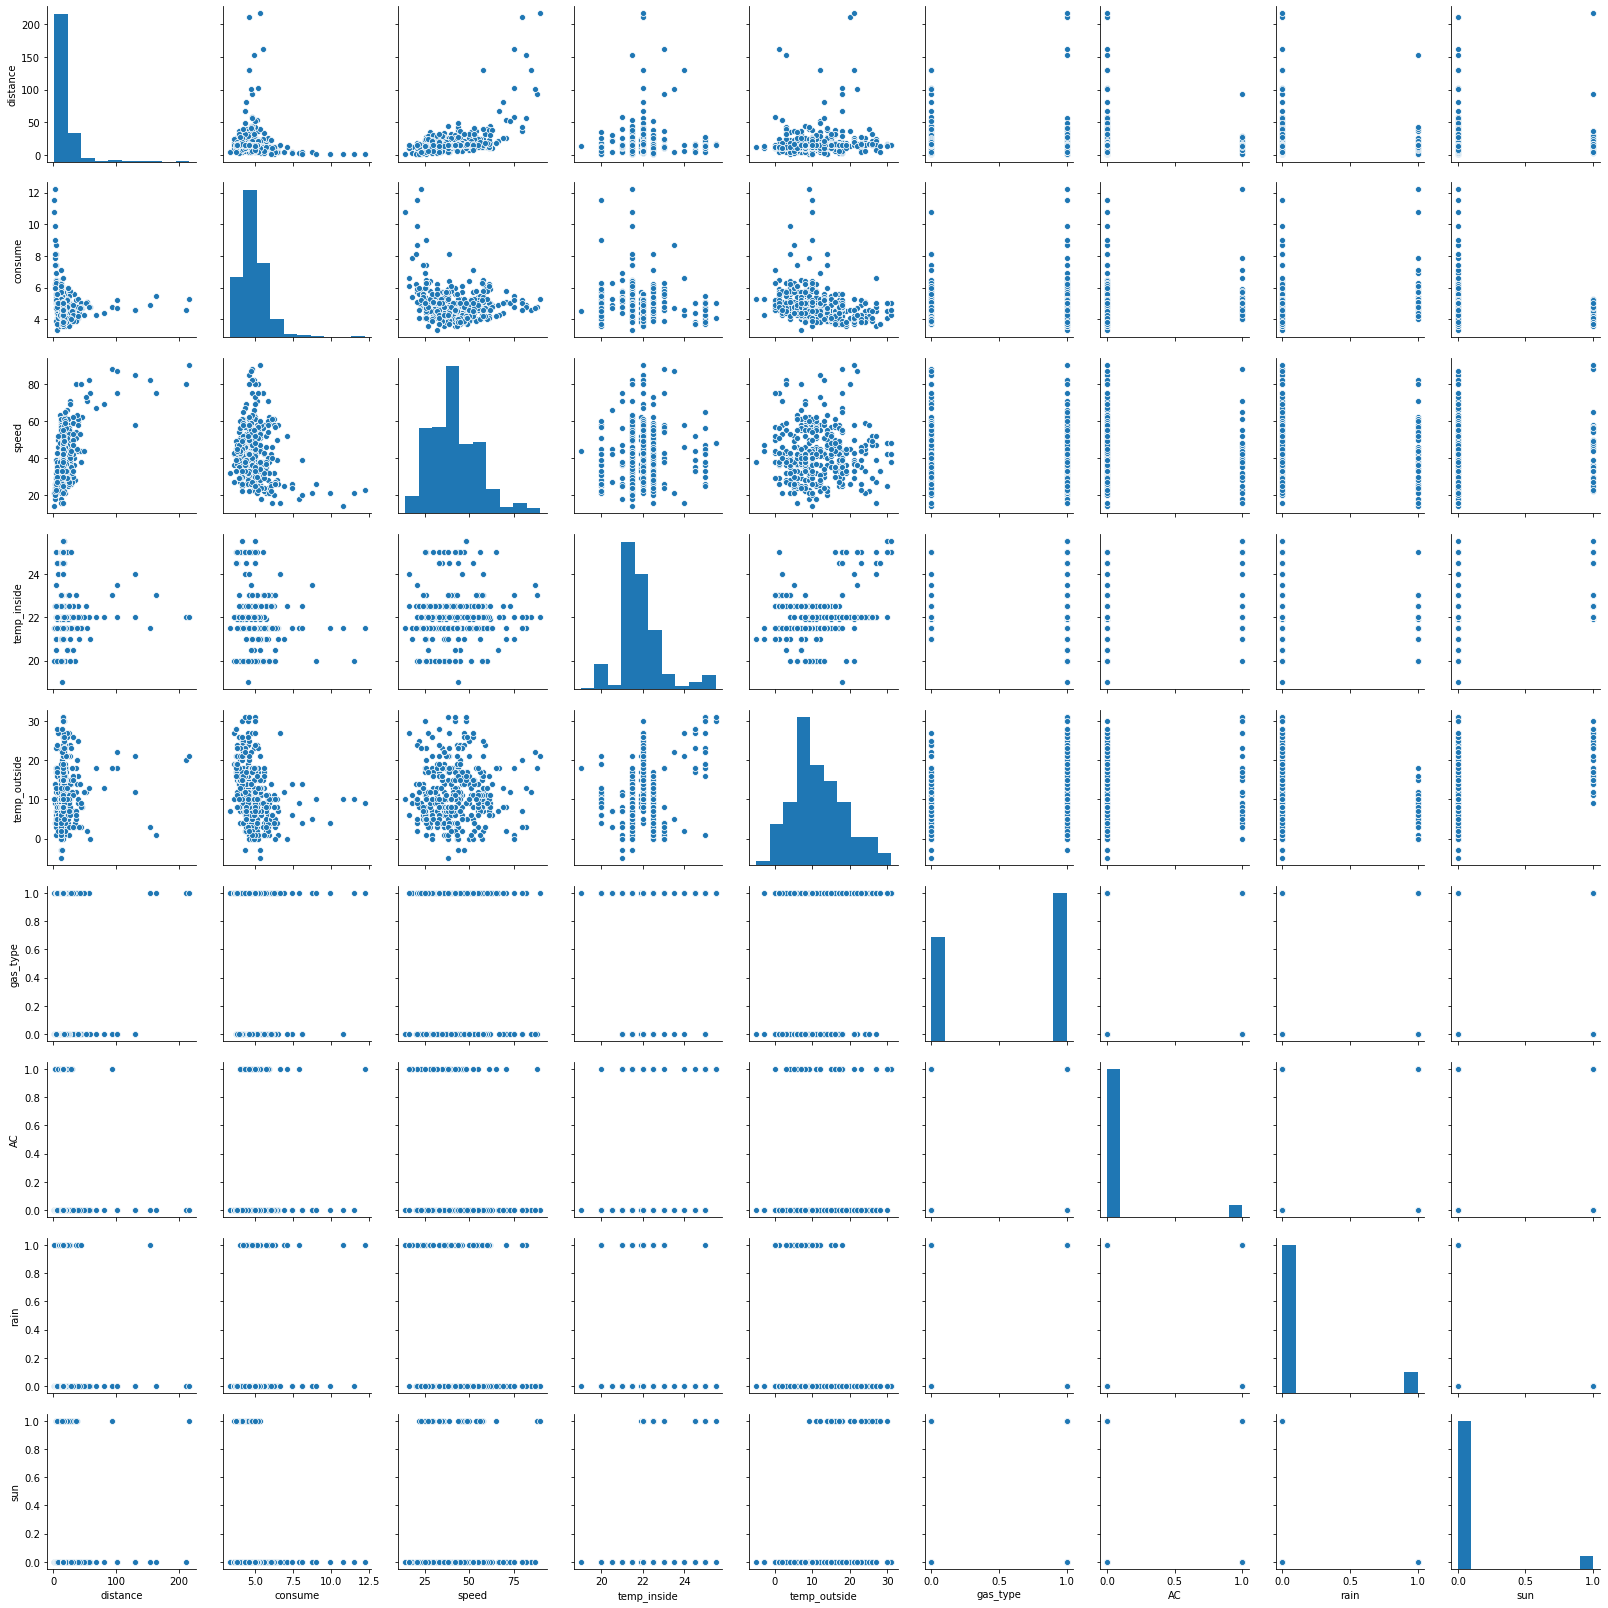

In [134]:
sns.pairplot(df_cp2)

# 4.目的変数と説明変数の設定

- 前回の検討にて説明変数が4変数よりも8変数の方がRMSEが小さくなったため8変数モデルを扱う

In [135]:
# consumeを目的変数に設定
y = df_cp2['consume'].values

# consume以外の8変数を説明変数に
X = df_cp2.drop(['consume'], axis=1).values

In [136]:
# 各変数の形状を確認
print(y.shape, X.shape)

(388,) (388, 8)


# 5.ホールドアウト法による線形近似

In [137]:
#X = x1.reshape(-1,1) # scikit-learnに入力するために整形

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

- `X_train` : 学習用データの説明変数
- `X_test` : テスト用データの説明変数
- `y_train` : 学習用データの目的変数
- `y_test` : テスト用データの目的変数

In [138]:
# 線形モデル作成
# 説明変数が8個
reg1 = LinearRegression(fit_intercept=True)
reg1.fit(X_train, y_train)

LinearRegression()

In [139]:
# 学習用データに対する予測を実行
y_pred_train = reg1.predict(X_train)

# 学習データに対する指標を計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

# 平均絶対誤差
print("MAE = %s"%round(mae,3) )
# 平均二乗誤差
print("MSE = %s"%round(mse,3) )
# 二乗平均平方根誤差
print("RMSE = %s"%round(rmse,3))
# 決定係数
print("R2 = %s"%round(r2,3))

MAE = 0.616
MSE = 0.891
RMSE = 0.944
R2 = 0.23


In [140]:
# テストデータに対する予測を実行
y_pred_test = reg1.predict(X_test)

# テストデータに対する指標を計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# 平均絶対誤差
print("MAE = %s"%round(mae,3) )
# 平均二乗誤差
print("MSE = %s"%round(mse,3) )
# 二乗平均平方根誤差
print("RMSE = %s"%round(rmse,3))
# 決定係数
print("R2 = %s"%round(r2,3))

MAE = 0.666
MSE = 0.676
RMSE = 0.822
R2 = 0.23


Text(0, 0.5, 'prediction')

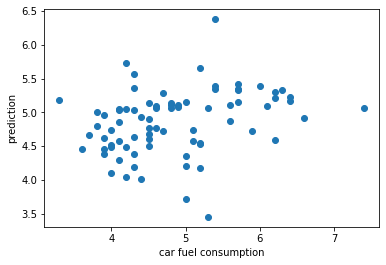

In [141]:
# 予測と実測の誤差を視覚化
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')

In [142]:
# 線形近似曲線のパラメータ算定
b = reg1.intercept_
w1 = reg1.coef_[0]
w2 = reg1.coef_[1]
w3 = reg1.coef_[2]
w4 = reg1.coef_[3]
w5 = reg1.coef_[4]
w6 = reg1.coef_[5]
w7 = reg1.coef_[6]
w8 = reg1.coef_[7]
print('b={:3f}, W1={:3f}, W2={:3f}, W3={:3f}, W4={:3f}, W5={:3f}, W6={:3f}, W7={:3f}, W8={:3f}'.format(b, w1,w2,w3,w4,w5,w6,w7,w8))

b=8.235774, W1=0.000878, W2=-0.019486, W3=-0.096395, W4=-0.039709, W5=-0.076159, W6=0.443882, W7=0.577469, W8=-0.188043


# 6.クロスバリデーション法による線形近似

In [143]:
#X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
cross_valid_mse = 0
cross_valid_rmse = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    reg2 = LinearRegression(fit_intercept=True)
    reg2.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = reg2.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    print("Fold %s"%split_num)
    # 平均絶対誤差
    print("MAE = %s"%round(mae,3) )
    # 平均二乗誤差
    print("MSE = %s"%round(mse,3) )
    # 二乗平均平方根誤差
    print("RMSE = %s"%round(rmse,3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    cross_valid_mse += mse #後で平均を取るためにMSEを加算
    cross_valid_rmse += rmse #後で平均を取るためにRMSEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))
# MSEの平均値を最終的な汎化誤差値とする
final_mse = cross_valid_mse / n_split
print("Cross Validation MSE = %s"%round(final_mse, 3))
# RMSEの平均値を最終的な汎化誤差値とする
final_rmse = cross_valid_rmse / n_split
print("Cross Validation RMSE = %s"%round(final_rmse, 3))

Fold 1
MAE = 0.666
MSE = 0.676
RMSE = 0.822

Fold 2
MAE = 0.619
MSE = 0.736
RMSE = 0.858

Fold 3
MAE = 0.742
MSE = 1.57
RMSE = 1.253

Fold 4
MAE = 0.61
MSE = 0.907
RMSE = 0.952

Fold 5
MAE = 0.518
MSE = 0.556
RMSE = 0.746

Cross Validation MAE = 0.631
Cross Validation MSE = 0.889
Cross Validation RMSE = 0.926


Text(0, 0.5, 'prediction')

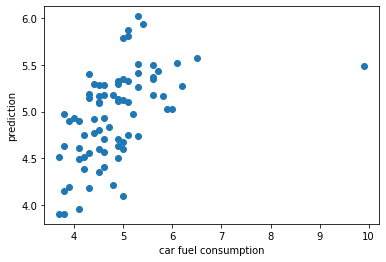

In [144]:
# 予測と実測の誤差を視覚化
# Fold5の予測値を利用
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')

In [145]:
# 線形近似曲線のパラメータ算定
# crossvalidationで最も指標が小さくなった最終foldout(Fold 5)からパラメータを持ってくる
b = reg2.intercept_
w1 = reg2.coef_[0]
w2 = reg2.coef_[1]
w3 = reg2.coef_[2]
w4 = reg2.coef_[3]
w5 = reg2.coef_[4]
w6 = reg2.coef_[5]
w7 = reg2.coef_[6]
w8 = reg2.coef_[7]
print('b={:3f}, W1={:3f}, W2={:3f}, W3={:3f}, W4={:3f}, W5={:3f}, W6={:3f}, W7={:3f}, W8={:3f}'.format(b, w1,w2,w3,w4,w5,w6,w7,w8))

b=8.304724, W1=0.002433, W2=-0.018212, W3=-0.104273, W4=-0.038191, W5=-0.044955, W6=0.512875, W7=0.541319, W8=-0.161522


# 7.NNによる線形近似

- ニューラルネットワークモデル条件の設定

In [146]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=8))
#model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(1, activation='linear'))

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

- trainデータとtestデータ作成
- その後，モデル計算

X_train: (310, 8)
y_train: (310,)
X_test: (78, 8)
y_test: (78,)


ValueError: x and y must be the same size

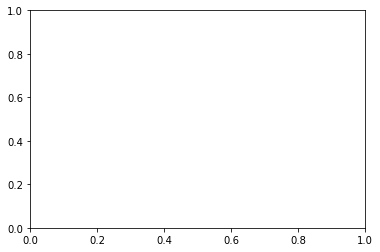

In [147]:
# ホールドアウト法でtrain,testデータを分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# 関連データのデータ形状確認
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

# 予測と実測の誤差を視覚化
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')

In [ ]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
# テストデータに対する予測を実行
y_pred_test = model.predict(X_test)

# テストデータに対する指標を計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# 平均絶対誤差
print("MAE = %s"%round(mae,3) )
# 平均二乗誤差
print("MSE = %s"%round(mse,3) )
# 二乗平均平方根誤差
print("RMSE = %s"%round(rmse,3))
# 決定係数
print("R2 = %s"%round(r2,3))

In [ ]:
# 予測と実測の誤差を視覚化
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')